# Wine Quality Prediction with Linear Regression

#### In this notebook, we train and evaluate linear regression models (using both the closed-form solution and gradient descent) on the Red Wine Quality dataset.

## Step 1: Imports and setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


## Step 2: (b) Load data and split into train/test

In [2]:
data = pd.read_csv("winequality-red.csv", delimiter=";")
data.columns = data.columns.str.strip()
display(data.head())
print("Shape:", data.shape)
print("Columns:", data.columns)

X = data.drop("quality", axis=1).values
y = data["quality"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Shape: (1599, 12)
Columns: Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')


## Step 3: (c) Using the closed-form solution

In [3]:
ones = np.ones((X_train.shape[0], 1))
X_train_aug = np.hstack([ones, X_train])
# Compute (X^T X)
XTX = X_train_aug.T @ X_train_aug

# Compute (X^T y)
XTy = X_train_aug.T @ y_train

# Solve for w
w_closed_form = np.linalg.solve(XTX, XTy)
print("Closed-form weights:", w_closed_form)


Closed-form weights: [ 1.43551052e+01  2.30853339e-02 -1.00130443e+00 -1.40821461e-01
  6.56431105e-03 -1.80650315e+00  5.62733439e-03 -3.64444893e-03
 -1.03515936e+01 -3.93687732e-01  8.41171623e-01  2.81889567e-01]


## Step 4: (d) Plot of the actual target values and predicted target values

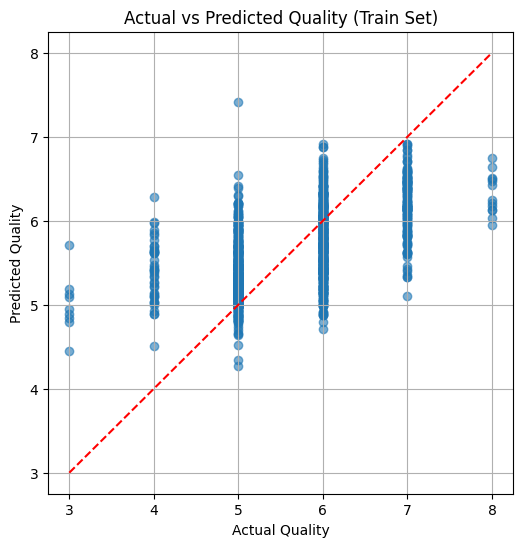

In [4]:
y_train_pred = X_train_aug @ w_closed_form

# Scatter plot: Actual vs Predicted
plt.figure(figsize=(6, 6))
plt.scatter(y_train, y_train_pred, alpha=0.6)
plt.xlabel("Actual Quality")
plt.ylabel("Predicted Quality")
plt.title("Actual vs Predicted Quality (Train Set)")

# Plot y = x reference line
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.grid(True)
plt.show()


## Step 5: (e) Report the root-mean-square on the train and test sets

In [5]:
# Define the RMSE Function
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

# Augmented design matrices and predictions
X_test_aug  = np.hstack([np.ones((X_test.shape[0], 1)),  X_test])
y_test_pred  = X_test_aug  @ w_closed_form

train_rmse = rmse(y_train, y_train_pred)
test_rmse  = rmse(y_test,  y_test_pred)

print("Train RMSE:", train_rmse)
print("Test RMSE: ", test_rmse)


Train RMSE: 0.6512995910592836
Test RMSE:  0.6245199307969643


The root-mean-square error (RMSE) on the training set is approximately 0.6513, while the RMSE on the test set is approximately 0.6245. The closeness of these values suggests that the model generalizes reasonably well to unseen data, with no significant overfitting or underfitting.

## Step 6: (f) Split the train set into a smaller train set and a validation set

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split full data into temp (90%) and test (10%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y, test_size=0.10, random_state=42
)

# Split temp (90%) into train (75%) and val (15%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=1/6, random_state=42
)

# 4. Add intercept terms (manually)
X_train_aug = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
X_val_aug   = np.hstack([np.ones((X_val.shape[0], 1)),   X_val])
X_test_aug  = np.hstack([np.ones((X_test.shape[0], 1)),  X_test])

## Step 7: (g) Implement the least-mean-squares algorithm

In [7]:
def lms_gradient_descent(X, y, w_init, eta, max_iter=1000, verbose=False):
    w = w_init.copy()
    losses = []

    for i in range(max_iter):
        y_pred = X @ w                         # prediction
        gradient = X.T @ (y_pred - y)          # gradient
        w -= eta * gradient                    # update step

        loss = 0.5 * np.mean((y_pred - y)**2)  # track MSE
        losses.append(loss)

        if verbose and i % 100 == 0:
            print(f"Iter {i:4d} | Loss: {loss:.4f}")

    return w, losses


## Step 8: (h) Use the validation set to select an appropriate step size $\eta$

In [8]:
# Define candidate sets
etas = [1e-5, 3e-5, 1e-4, 3e-4, 5e-4, 6e-4, 7e-4, 1e-3, 3e-3]

# Randomly initialize w^0
np.random.seed(42) 
w0_dist = np.random.randn(X_train.shape[1] + 1)  # +1 for intercept term

best_eta = None
best_val_rmse = float("inf")
rmse_results = {}

for eta in etas:
    w_init = np.random.randn(X_train.shape[1] + 1)  # fresh init per trial
    w_eta, _ = lms_gradient_descent(X_train_aug, y_train, w_init, eta, max_iter=1000)

    y_val_pred = X_val_aug @ w_eta
    val_rmse = rmse(y_val, y_val_pred)

    rmse_results[eta] = val_rmse
    print(f"η = {eta:.0e} → Validation RMSE = {val_rmse:.4f}")

    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        best_eta = eta

print(f"\n Best η selected: {best_eta} with validation RMSE = {best_val_rmse:.4f}")



η = 1e-05 → Validation RMSE = 0.6295
η = 3e-05 → Validation RMSE = 0.6019
η = 1e-04 → Validation RMSE = 0.6016
η = 3e-04 → Validation RMSE = 0.6016
η = 5e-04 → Validation RMSE = 0.6016
η = 6e-04 → Validation RMSE = 6156319045121166661010775686980810125100887094195520369674898295198996832069020981133312.0000
η = 7e-04 → Validation RMSE = inf
η = 1e-03 → Validation RMSE = nan
η = 3e-03 → Validation RMSE = nan

 Best η selected: 0.0001 with validation RMSE = 0.6016


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/var/folders/xr/m551d0ds2399b7q4w_r7m08w0000gn/T/ipykernel_58072/2679899615.py:10: RuntimeWarning: overflow encountered in square
  loss = 0.5 * np.mean((y_pred - y)**2)  # track MSE
/var/folders/xr/m551d0ds2399b7q4w_r7m08w0000gn/T/ipykernel_58072/692983333.py:3: RuntimeWarning: overflow encountered in square
  return np.sqrt(np.mean((y_true - y_pred) ** 2))
/var/folders/xr/m551d0ds2399b7q4w_r7m08w0000gn/T/ipykernel_58072/2679899615.py:7: RuntimeWarning: overflow encountered in matmul
  gradient = X.T @ (y_pred - y)          # gradient
/var/folders/xr/m551d0ds2399b7q4w_r7m08w0000gn/T/ipykernel_58072/2679899615.py:6: RuntimeWarning: invalid value encountered in matmul
  y_pred = X @ w                         # prediction


Therefore, we should choose $\eta=0.0001$, which leads to Validation RMSE = 0.6016.

## Step 9: (i) Train the model on the complete train set with selected $\eta$

In [9]:
# Combine original train and validation sets
X_full_train = np.vstack([X_train, X_val])
y_full_train = np.concatenate([y_train, y_val])

# Add intercept term (column of 1s)
X_full_train_aug = np.hstack([np.ones((X_full_train.shape[0], 1)), X_full_train])

# Random initialization for w(0)
np.random.seed(0)
w_init_final = np.random.randn(X_full_train_aug.shape[1])

# Train LMS using selected eta and full training data
best_eta = 0.0001 
w_final, loss_history = lms_gradient_descent(
    X_full_train_aug, y_full_train, w_init_final, best_eta, max_iter=1000
)


## Step 10: (j)  Report the root-mean-square error on train and test sets

In [10]:
# Augment X_test with intercept term
X_test_aug = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

# Predictions
y_train_pred = X_full_train_aug @ w_final
y_test_pred  = X_test_aug @ w_final

# RMSEs
train_rmse = rmse(y_full_train, y_train_pred)
test_rmse  = rmse(y_test, y_test_pred)

print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test  RMSE: {test_rmse:.4f}")


Train RMSE: 0.6486
Test  RMSE: 0.6194


After training the final LMS model on the full training set using $\eta=0.0001$, we evaluated the RMSE on both the training and test sets. The results are 

Train RMSE: 0.6486 and Test  RMSE: 0.6194.